# PyFixest on the GPU via JAX

Through its JAX integration, it is possible to run PyFixest on the GPU. In this notebook, we benchmark the performance of PyFixest on the GPU via its 
`jax` backend and compare it to the performance of PyFixest on the CPU (via the default `numba` backend). 

All dependencies to run this notebook are available in the `docs` environment. 

In [1]:
import time
from itertools import product

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from pyfixest.estimation.demean_ import demean
from pyfixest.estimation.demean_jax_ import demean_jax
from scipy.stats import nbinom
from tqdm import tqdm

import pyfixest as pf

rng = np.random.default_rng(239291)

In [2]:
%load_ext watermark
%watermark

Last updated: 2025-01-10T22:33:11.321606+01:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
# checking GPU connection
jax.devices()

INFO:2025-01-10 22:33:11,368:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-10 22:33:11,374:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


[CpuDevice(id=0)]

In [4]:
jnp.ones(10).devices()

{CpuDevice(id=0)}

In [5]:
# checking GPU availability
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


First, we define a function to simulate a test data set which closely mimics the data generating process in the original fixest benchmarks 
that produced the data for [this figure](https://raw.githubusercontent.com/lrberge/fixest/refs/heads/master/vignettes/images/benchmark_gaussian.png).

In one slight adjustment, we allow to vary the number of regressors `k`, which in the original fixest dgp is always set to 1. 

In [6]:
def generate_test_data(rng: np.random.Generator, size: int = 1, k: int = 2):
    """
    Generate benchmark data for pyfixest on GPU (similar to the R fixest benchmark data).

    Args:
        rng (np.random.Generator): A numpy random number generator.
        size (int): The number of observations in the data frame.
        k (int): The number of covariates in the data frame.

    Returns
    -------
        pd.DataFrame: The generated data frame for the given size.
    """
    # Constants
    all_n = [1000 * 10**i for i in range(5)]
    a = 1
    b = 0.05

    n = all_n[size - 1]

    dum_all = []
    nb_dum = [n // 20, int(np.sqrt(n)), int(n**0.33)]

    dum_all = np.zeros((n, 3))
    dum_all[:, 0] = rng.choice(nb_dum[0], n, replace=True)
    dum_all[:, 1] = rng.choice(nb_dum[1], n, replace=True)
    dum_all[:, 2] = rng.choice(nb_dum[2], n, replace=True)
    dum_all = dum_all.astype(int)

    X1 = rng.normal(size=n)
    X2 = X1**2

    mu = a * X1 + b * X2

    for m in range(3):
        coef_dum = rng.normal(size=nb_dum[m])
        mu += coef_dum[dum_all[:, m]]

    mu = np.exp(mu)
    y = nbinom.rvs(0.5, 1 - (mu / (mu + 0.5)), size=n, random_state=rng)

    X_full = np.column_stack((X1, X2))
    base = pd.DataFrame(
        {
            "y": y,
            "ln_y": np.log1p(y),
            "X1": X1,
            "X2": X2,
        }
    )

    if k > 2:
        X = rng.normal(size=(n, k - 2))
        X_df = pd.DataFrame(X, columns=[f"X{i}" for i in range(3, k + 1, 1)])
        base = pd.concat([base, X_df], axis=1)
        X_full = np.column_stack((X_full, X))

    for m in range(3):
        base[f"dum_{m + 1}"] = dum_all[:, m]

    weights = rng.uniform(0, 1, n)
    return base, y, X_full, dum_all, weights

In [7]:
df, Y, X, f, weights = generate_test_data(rng=rng, size=1)

We can now test the two backend based on the test data set:

In [8]:
m0 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="numba")
m1 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="jax")
pf.etable([m0, m1], digits=6)

GT(_tbl_data=  level_0        level_1                            0  \
0    coef             X1  0.257668*** <br> (0.029134)   
1      fe          dum_1                            x   
2   stats   Observations                         1000   
3   stats      S.E. type                    by: dum_1   
4   stats  R<sup>2</sup>                     0.283080   

                             1  
0  0.257668*** <br> (0.029134)  
1                            x  
2                         1000  
3                    by: dum_1  
4                     0.283080  , _body=<great_tables._gt_data.Body object at 0x000001D338E01580>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001D3384C89E0>, _spanners=Spanners([SpannerInfo(spanner_id='ln_y', spanner_level=1, spanner_label='ln_y', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001D3384C8650>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=True, category='table

We know define a single function to run a benchmark for a given sample size `size = i x 1000`, number of regressors `k`, solver, 
and demeaning backend. Additionally, the function allows us to specify a set of fixed effects and if we want to run benchmarks only 
for a full call to `pf.feols()`, or if we additionally want to benchmark the demeaning process. 

In [ ]:
def run_standard_benchmark(
    rng,
    fixed_effect,
    demeaner_backend,
    size=1,
    k=1,
    solver="np.linalg.lstsq",
    skip_demean_benchmark=True,
):
    """
    Run the fixest standard benchmark fixed effect models. This is the function the benchmarks
    will loop over.

    Args:
        rng (np.random.Generator): A numpy random number generator.
        fixed_effect (str): The fixed effect to use. Must be a list of variables as "dum_1", "dum_1+dum_2", or "dum_1+dum_2+dum_3", etc.
        demeaner_backend (str): The backend to use for demeaning. Must be "numba" or "jax".
        size (int): The size of the data to generate. Must be between 1 and 5. For 1, N = 1000, for 2, N = 10000, etc.
        k_vals (int): The number of covariates to generate.
        solver (str): The solver to use for the estimation. Must be "np.linalg.lstsq". "jax" currently throws an error.
        skip_demean_benchmark (bool): Whether to skip the "pure" demean benchmark. Default is True. Only the full call
            to feols is benchmarked.

    """
    assert fixed_effect in ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"]

    # one fixed effect
    res = []

    fml_base = "ln_y ~ X1"
    fml = f"{fml_base} | {fixed_effect}"

    # warmup
    df, _, X, f, weights = generate_test_data(rng=rng, size=1)
    pf.feols(
        fml,
        data=df,
        demeaner_backend=demeaner_backend,
        store_data=False,
        copy_data=False,
        solver=solver,
    )

    if not skip_demean_benchmark:
        if demeaner_backend == "jax":
            _, _ = demean_jax(X, f, weights, tol=1e-10)
        else:
            _, _ = demean(X, f, weights, tol=1e-10)

    if k > 1:
        xfml = "+".join([f"X{i}" for i in range(2, k + 1, 1)])
        fml = f"{fml_base} + {xfml} | {fixed_effect}"
    else:
        fml = f"{fml_base} + X1 | {fixed_effect}"

    for rep in range(1, 11):
        df, Y, X, f, weights = generate_test_data(rng=rng, size=size, k=k)

        tic1 = time.time()
        pf.feols(
            fml,
            data=df,
            demeaner_backend=demeaner_backend,
            store_data=False,
            copy_data=False,
            solver=solver,
        )
        tic2 = time.time()

        full_feols_timing = tic2 - tic1

        demean_timing = np.nan
        if not skip_demean_benchmark:
            YX = np.column_stack((Y.reshape(-1, 1), X))
            tic3 = time.time()
            if demeaner_backend == "jax":
                _, _ = demean_jax(YX, f, weights, tol=1e-10)
            else:
                _, _ = demean(YX, f, weights, tol=1e-10)
            tic4 = time.time()
            demean_timing = tic4 - tic3

        res.append(
            pd.Series(
                {
                    "method": "feols",
                    "solver": solver,
                    "demeaner_backend": demeaner_backend,
                    "n_obs": df.shape[0],
                    "k": k,
                    "G": len(fixed_effect.split("+")),
                    "rep": rep,
                    "full_feols_timing": full_feols_timing,
                    "demean_timing": demean_timing,
                }
            )
        )

    return pd.concat(res, axis=1).T

## A first simple benchmark 

For a simple example, we see that `pf.feols()` does not spend a lot of time on the demeaning step.

In [10]:
# test run numba
run_standard_benchmark(
    rng=rng,
    fixed_effect="dum_1",
    demeaner_backend="numba",
    size=1,
    k=1,
    skip_demean_benchmark=False,
)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,numba,1000,1,1,1,0.160429,0.0
1,feols,np.linalg.lstsq,numba,1000,1,1,2,0.131225,0.0
2,feols,np.linalg.lstsq,numba,1000,1,1,3,0.131626,0.0
3,feols,np.linalg.lstsq,numba,1000,1,1,4,0.135497,0.001003
4,feols,np.linalg.lstsq,numba,1000,1,1,5,0.130112,0.001006
5,feols,np.linalg.lstsq,numba,1000,1,1,6,0.133429,0.0
6,feols,np.linalg.lstsq,numba,1000,1,1,7,0.147166,0.0
7,feols,np.linalg.lstsq,numba,1000,1,1,8,0.140105,0.000984
8,feols,np.linalg.lstsq,numba,1000,1,1,9,0.158601,0.001009
9,feols,np.linalg.lstsq,numba,1000,1,1,10,0.156101,0.000999


In [11]:
# test run jax
run_standard_benchmark(
    rng=rng,
    fixed_effect="dum_1",
    demeaner_backend="jax",
    size=1,
    k=1,
    skip_demean_benchmark=False,
)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,jax,1000,1,1,1,0.146162,0.196979
1,feols,np.linalg.lstsq,jax,1000,1,1,2,0.146127,0.011776
2,feols,np.linalg.lstsq,jax,1000,1,1,3,0.153895,0.012497
3,feols,np.linalg.lstsq,jax,1000,1,1,4,0.164696,0.012709
4,feols,np.linalg.lstsq,jax,1000,1,1,5,0.147778,0.012649
5,feols,np.linalg.lstsq,jax,1000,1,1,6,0.156842,0.012004
6,feols,np.linalg.lstsq,jax,1000,1,1,7,0.144683,0.012104
7,feols,np.linalg.lstsq,jax,1000,1,1,8,0.144666,0.011525
8,feols,np.linalg.lstsq,jax,1000,1,1,9,0.138009,0.009692
9,feols,np.linalg.lstsq,jax,1000,1,1,10,0.13397,0.01277


## Systematic benchmarking

We now want to run more systematic benchmarks on differences in performance on CPU vs GPU. 
We will run benchmarks for different sets of fixed effects, sample sizes, and number of regressors. Our workhorse 
function for the task is `run_all_benchmarks` defined below: 

In [12]:
def run_all_benchmarks(rng, size_list, k_list, skip_demean_benchmark):
    """
    Run all the benchmarks.

    Args:
        rng (np.random.Generator): A numpy random number generator.
        size_list (list): The list of sizes to run the benchmarks on. 1-> 1000, 2-> 10000, ..., 5-> 10_000_000
        k_list (list): The list of k values to run the benchmarks on.
        skip_demean_benchmark (bool): Whether to skip the "pure" demean benchmark.
    """
    res = pd.DataFrame()

    all_combinations = list(
        product(
            ["numba", "jax"],  # demeaner_backend
            ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"],  # fixef
            size_list,  # size
            k_list,  # k
            ["np.linalg.lstsq"],  # solver
        )
    )

    with tqdm(total=len(all_combinations), desc="Running Benchmarks") as pbar:
        for demeaner_backend, fixef, size, k, solver in all_combinations:
            res = pd.concat(
                [
                    res,
                    run_standard_benchmark(
                        rng=rng,
                        solver=solver,
                        fixed_effect=fixef,
                        demeaner_backend=demeaner_backend,
                        size=size,
                        k=k,
                        skip_demean_benchmark=skip_demean_benchmark,
                    ),
                ],
                axis=0,
            )
            pbar.update(1)  # Update the progress bar after each iteration

    return res

## Run Benchmarks

In [14]:
res_all = run_all_benchmarks(
    rng=rng,
    size_list=[2, 3, 4, 5],  # for N = 10_000, 100_000, 1_000_000, 10_000_000
    k_list=[1, 10, 50, 100],  # for k = 1, 10, 50, 100
    skip_demean_benchmark=False,
)

Running Benchmarks: 100%|██████████| 24/24 [02:38<00:00,  6.59s/it]


In [15]:
df = (
    res_all.drop(["rep", "solver"], axis=1)
    .groupby(["method", "demeaner_backend", "k", "G", "n_obs"])
    .mean()
    .reset_index()
)
df.head()

,method,demeaner_backend,k,G,n_obs,full_feols_timing,demean_timing
0,feols,jax,1,1,10000,0.22884,0.082133
1,feols,jax,1,1,100000,0.278382,0.659936
2,feols,jax,1,2,10000,0.259413,0.070082
3,feols,jax,1,2,100000,0.556465,0.676255
4,feols,jax,1,3,10000,0.29452,0.080892


In [16]:
df.to_csv("gpu_results.csv")

## Visualize Results

In [17]:
def visualize_results(data, kpi):
    """
    Visualize benchmark results.

    Args:
        data (pd.DataFrame): The benchmark results data frame.
        kpi (str): The key performance indicator to plot. Must be one of "full_feols_timing" or "demean_timing".
    """
    df["G2"] = df["G"].map({1: "n_fixef = 1", 2: "n_fixef = 2", 3: "n_fixef = 3"})
    df["n_obs"] = df["n_obs"].astype(str)

    n_obs_order = sorted(df["n_obs"].unique(), key=lambda x: int(x))
    demeaner_backend_order = df["demeaner_backend"].unique()

    custom_palette = sns.color_palette("coolwarm", n_colors=2)

    cat_plot = sns.catplot(
        data=df,
        x="n_obs",
        y=kpi,
        hue="demeaner_backend",
        col="G2",
        row="k",
        kind="bar",
        palette=custom_palette,
        order=n_obs_order,
        hue_order=demeaner_backend_order,
        height=4,
        aspect=1.2,
        col_order=["n_fixef = 1", "n_fixef = 2", "n_fixef = 3"],
    )

    # Set logarithmic scale on the y-axis
    def log_scale(ax, y_label):
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=None, numticks=10))
        ax.set_ylabel(y_label)

    for ax in cat_plot.axes.flat:
        log_scale(ax, "Runtime (log seconds)")

    cat_plot.set_axis_labels("Number of Observations", "Runtime (log seconds)")
    cat_plot.set_titles(row_template="k = {row_name}", col_template="{col_name}")
    plt.subplots_adjust(top=0.9)
    cat_plot.fig.suptitle(
        f"{kpi}: Runtime vs Number of Observations by n_fixef fixed effects and k regressors. Y Axis on the Log Scale"
    )

    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


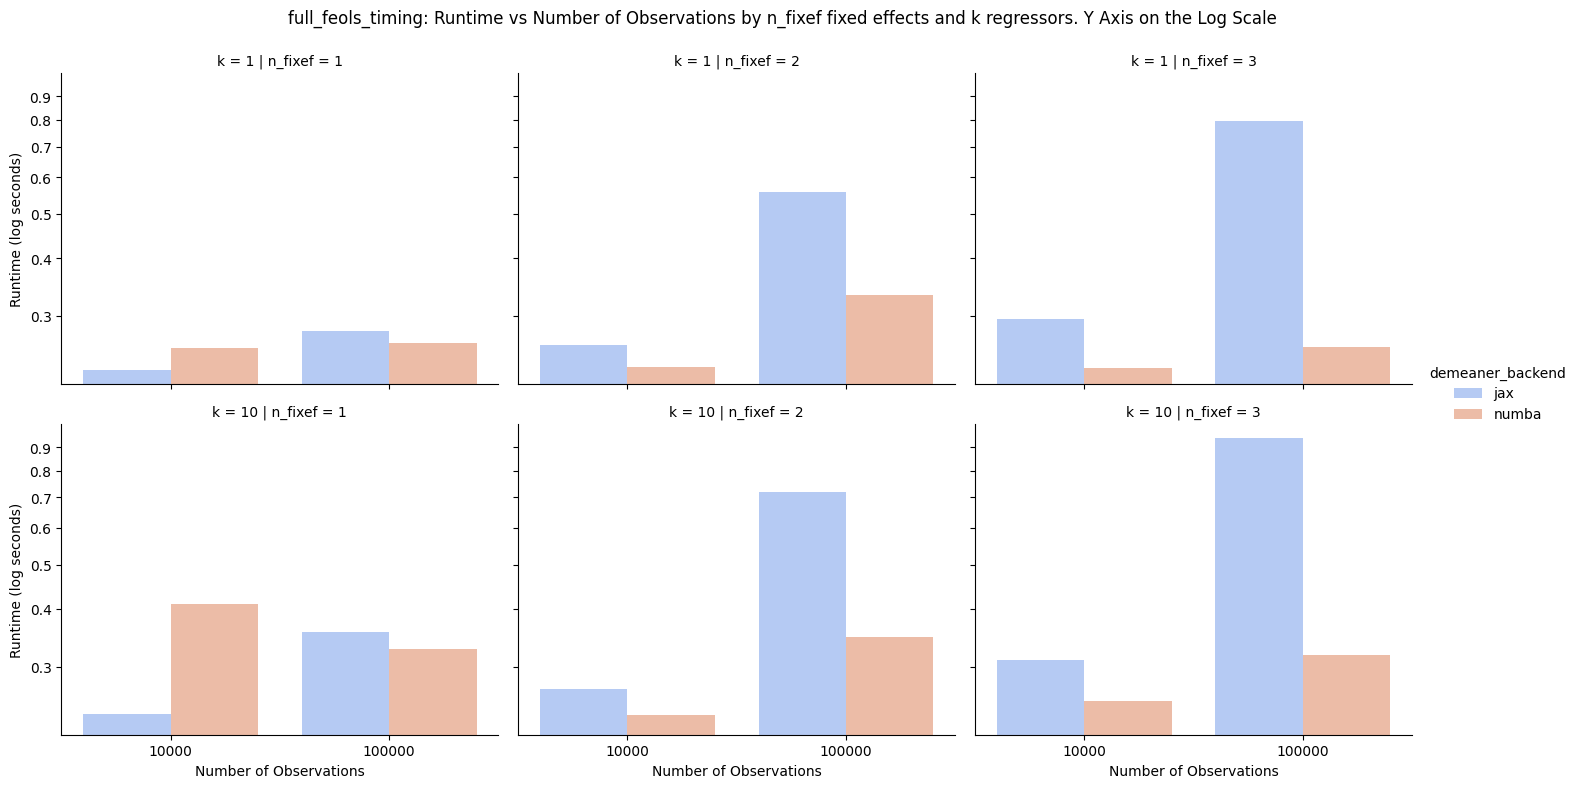

In [18]:
visualize_results(df, "full_feols_timing")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


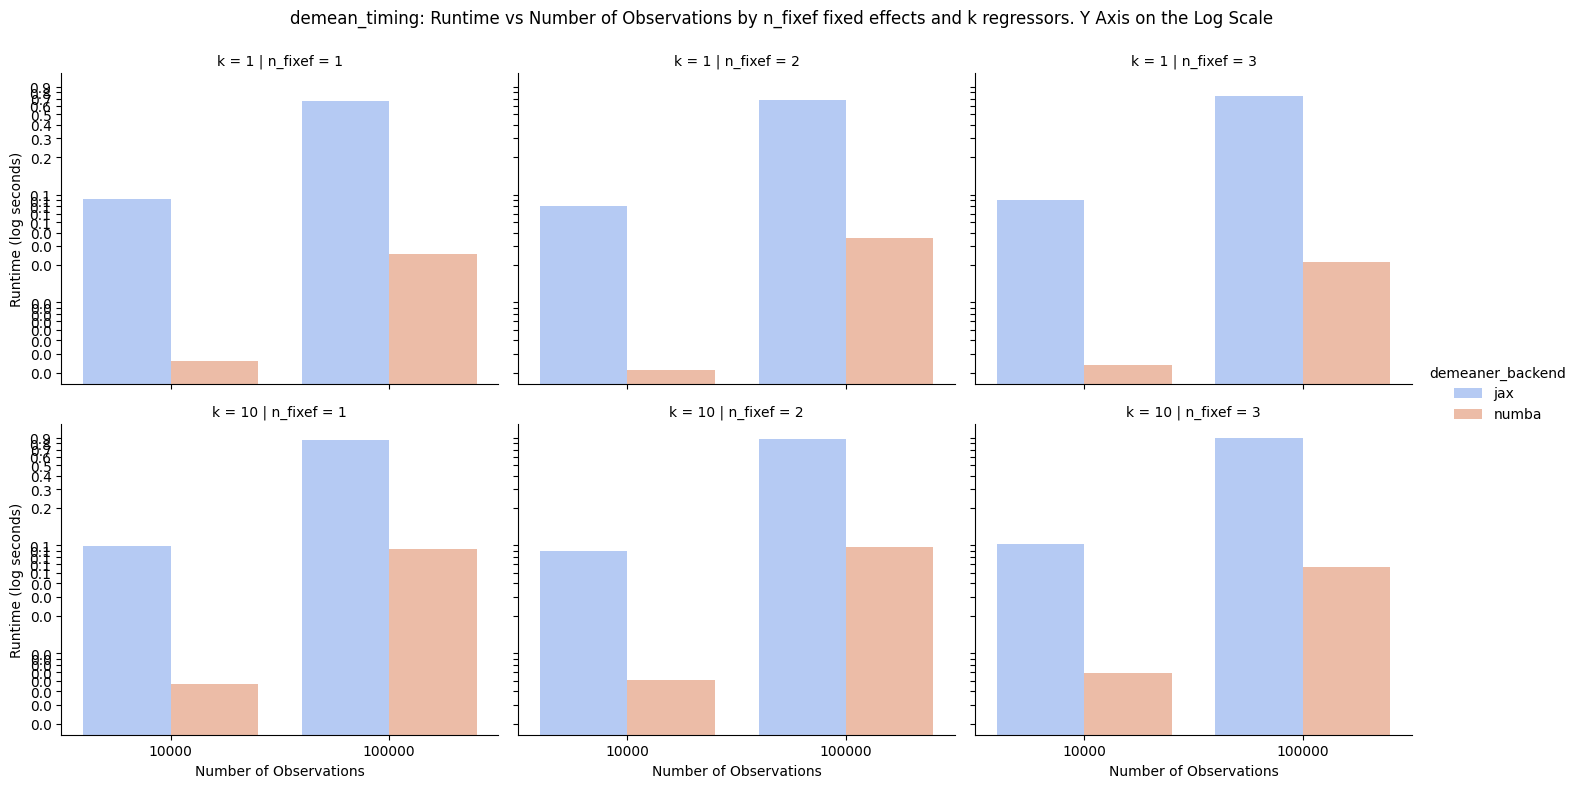

In [19]:
visualize_results(df, "demean_timing")